In [108]:
from utils.load_dataset import PlantVillageDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, Subset
from utils.preprocessing import preprocessing_img
import torchvision.models  as models
from torchvision import transforms
import numpy as np

## Vizualize the data

In [109]:
# Load the dataset
PATH = './Plant_leave_diseases_dataset_without_augmentation'
transform = transforms.Compose([
    preprocessing_img,
    transforms.ToTensor(),
])
training_data = PlantVillageDataset(PATH, img_mode="LAB", train=True, transform=transform, test_split=0.3)
validation_data  = PlantVillageDataset(PATH, img_mode="LAB", train=False, transform=transform, test_split=0.3)

In [110]:
n_models = 4
indices = np.random.permutation(len(training_data))
model_sets = [Subset(training_data, indices[i::n_models]) for i in range(n_models)]
test_size = int(0.2 * len(model_sets[0]))  # 20% for testing
train_size = len(model_sets[0]) - test_size  # Remaining 80%
train_set = []
test_set = []
for i in range(n_models):
    train, test = random_split(model_sets[i], [train_size, test_size])
    train_set.append(train)
    test_set.append(test)

In [111]:
test_size = int(0.2 * len(validation_data))
train_validation_set, test_validation_set = random_split(validation_data, [len(validation_data) - test_size, test_size])

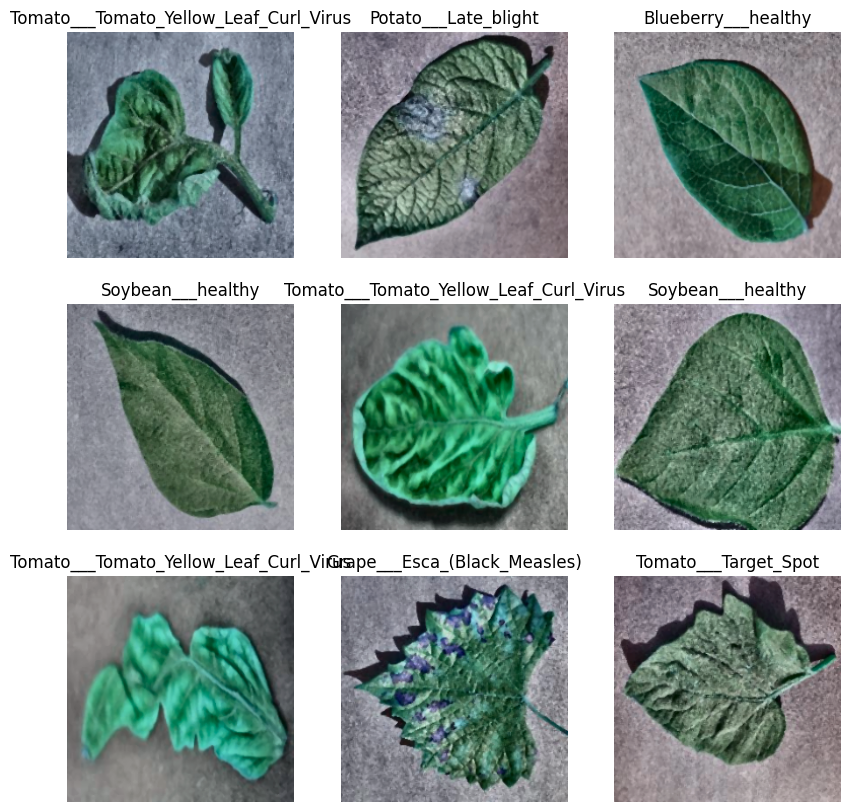

In [112]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(training_data.label_to_idx.keys())[label])
    plt.axis("off")
    plt.imshow(img.swapaxes(0,2))
plt.show()

## Create Loaders

In [113]:
train_dataloaders = [DataLoader(train_data, batch_size=64, shuffle=True) for train_data in train_set ]
test_dataloaders = [DataLoader(test_data, batch_size=64, shuffle=True) for test_data in test_set ]

## Load Models

In [114]:
# ResNet50
resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet50.parameters():
    param.requires_grad = False

# DenseNet201
densenet = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
for param in densenet.parameters():
    param.requires_grad = False

# EfficientNetB0
efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in efficientnet_b0.parameters():
    param.requires_grad = False

# EfficientNetB3
efficientnet_b3 = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
for param in efficientnet_b3.parameters():
    param.requires_grad = False

In [119]:
models_list = [resnet50, densenet, efficientnet_b0, efficientnet_b3]

## Set Device

In [115]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Linear Model

In [116]:
# Linear Model
import torch.nn as nn
class LinearHeadModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, dropout_rate=0.25):
        super(LinearHeadModel, self).__init__()
        #self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, output_dim),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.linear_layers(x)
        return x

## Train Model

In [117]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

In [118]:
# Hyperparameters
num_classes = 38

In [132]:
def train_linear_model(index, input_dim, num_classes):
    
    # Get pre-trained model
    pre_trained_model = models_list[index]

    # Set model to device
    pre_trained_model = pre_trained_model.to(device)

    # Create linear head model and add it to the pre-trained-model
    model_linear_classifier = LinearHeadModel(input_dim, num_classes + 1)

    if index == 0:
        pre_trained_model.fc = model_linear_classifier.to(device)
        parameters = pre_trained_model.fc.parameters()
    
    else :
        pre_trained_model.classifier = model_linear_classifier.to(device)
        parameters = pre_trained_model.classifier.parameters()

    # Train model
    train_model(pre_trained_model, train_dataloaders[index], nn.CrossEntropyLoss(), torch.optim.Adam(parameters, lr=0.001))
    

    if index == 0:
        return pre_trained_model.fc
    else :
        return pre_trained_model.classifier

## Train models

### ResNet50

In [148]:
resnet50_classifier = train_linear_model(0, 2048, num_classes)

Epoch 1/10, Loss: 3.2979825091087953
Epoch 2/10, Loss: 3.0700281913253082
Epoch 3/10, Loss: 2.979270148551327
Epoch 4/10, Loss: 2.9386925765837746
Epoch 5/10, Loss: 2.904175073250957
Epoch 6/10, Loss: 2.882480292484678
Epoch 7/10, Loss: 2.8654765493568335
Epoch 8/10, Loss: 2.856037300208519
Epoch 9/10, Loss: 2.8406048629475737
Epoch 10/10, Loss: 2.827593971943033


### Densenet

In [146]:
densenet_classifier = train_linear_model(1, 1920, num_classes)

Epoch 1/10, Loss: 3.225225225262258
Epoch 2/10, Loss: 2.9474170591639375
Epoch 3/10, Loss: 2.876445614058396
Epoch 4/10, Loss: 2.848184884279624
Epoch 5/10, Loss: 2.8321321421656114
Epoch 6/10, Loss: 3.1176161067239168
Epoch 7/10, Loss: 3.6048770649679778
Epoch 8/10, Loss: 3.6041785437485268
Epoch 9/10, Loss: 3.6037946199548654
Epoch 10/10, Loss: 3.6044653448565254


### EfficientNetB0

In [144]:
efficientnet_b0_classifier = train_linear_model(2, 1280, num_classes)

Epoch 1/10, Loss: 3.3414642810821533
Epoch 2/10, Loss: 3.114514830468715
Epoch 3/10, Loss: 2.9930238751159317
Epoch 4/10, Loss: 2.9549609134937156
Epoch 5/10, Loss: 2.9271589407975647
Epoch 6/10, Loss: 2.913892696643698
Epoch 7/10, Loss: 2.8895182267002677
Epoch 8/10, Loss: 2.8787667326543525
Epoch 9/10, Loss: 2.8738976264822074
Epoch 10/10, Loss: 2.862105477815387


### EfficientNetB3

In [137]:
efficientnet_b3_classifier = train_linear_model(3, 1536, num_classes)

Epoch 1/10, Loss: 3.346330119275499
Epoch 2/10, Loss: 3.144192396909341
Epoch 3/10, Loss: 3.0795011040808142
Epoch 4/10, Loss: 3.02436131718515
Epoch 5/10, Loss: 2.9967938017571107
Epoch 6/10, Loss: 2.9843064149220786
Epoch 7/10, Loss: 2.971754793463082
Epoch 8/10, Loss: 2.9660188877719573
Epoch 9/10, Loss: 2.954396605491638
Epoch 10/10, Loss: 2.9500138129311044


## Save models

In [115]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Final model saved to {path}")

In [140]:
# Paths for saving
densenet201_path = "densenet201.pth"
efficientnet_b0_path = "efficientnet_b0.pth"
efficientnet_b3_path = "efficientnet_b3.pth"
resnet50_path = "resnet50.pth"

In [149]:
save_model(resnet50_classifier, f'models/{resnet50_path}')
save_model(densenet_classifier, f'models/{densenet201_path}')
save_model(efficientnet_b0_classifier, f'models/{efficientnet_b0_path}')
save_model(efficientnet_b3_classifier, f'models/{efficientnet_b3_path}')

Final model saved to models/resnet50.pth
Final model saved to models/densenet201.pth
Final model saved to models/efficientnet_b0.pth
Final model saved to models/efficientnet_b3.pth
